# Credit Card Fraud Predictor

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import stats
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score ,classification_report

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
# load the data
raw = pd.read_csv('creditcard.csv')
print(raw.shape)

(284807, 31)


In [3]:
# Check out the data a bit
print('The number of null values is:')
print(raw.isnull().sum().sum())
print(raw.describe(include='all'))

raw.drop_duplicates()
print(raw.shape)

The number of null values is:
0
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.3

The data set is quite large with almost 300K observations.  We are trying to predict credit card fraud which is the Class variable.  It is a binary variable where 1 represents fraud.  Based on the description of the variable it looks like there are not a lot of frauds in the data.  Of the 30 independent variables it appears that there are 28 V variables that are roughly on the same scale where the time and amount variables are different.  The time variable represents the number of seconds elapsed between this transaction and the first transaction in the dataset.  The amount variable represents the transaction amount.  It also appears that there is an outlier in the amount variable.

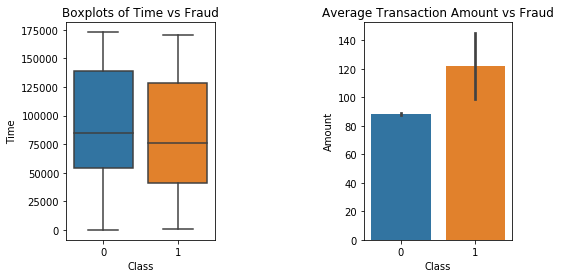

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,4), gridspec_kw={'wspace': 1})

sns.boxplot(x='Class', y='Time', data=raw, ax=ax1)
ax1.set_title('Boxplots of Time vs Fraud')
sns.barplot(x='Class', y='Amount', data=raw, ax=ax2)
ax2.set_title('Average Transaction Amount vs Fraud')
plt.show()

We can see that there is a shorter amount of time spent between transactions for fraudulent cases, which is what we might expect - a thief is working as fast as possible to take the money before he/she is discovered.  The average transaction amount is also higher for fraud as well.

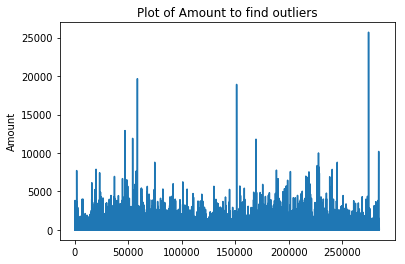

In [5]:
raw.Amount.plot()
plt.title('Plot of Amount to find outliers')
plt.ylabel('Amount')
plt.show()

In [6]:
# Let's cap the amount column at 10,000
raw.Amount[raw['Amount'] >= 10000] = 10000
print(raw.Amount.describe())

count    284807.000000
mean         88.205466
std         241.201158
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       10000.000000
Name: Amount, dtype: float64


In [7]:
# now let's standardize the time and amount column
raw[['Time','Amount']] = raw[['Time','Amount']].apply(lambda x: scipy.stats.zscore(x))
print(raw[['Time','Amount']].describe())

               Time        Amount
count  2.848070e+05  2.848070e+05
mean  -3.065637e-16 -4.989644e-17
std    1.000002e+00  1.000002e+00
min   -1.996583e+00 -3.656932e-01
25%   -8.552120e-01 -3.424760e-01
50%   -2.131453e-01 -2.744829e-01
75%    9.372174e-01 -4.577293e-02
max    1.642058e+00  4.109355e+01


0    284315
1       492
Name: Class, dtype: int64


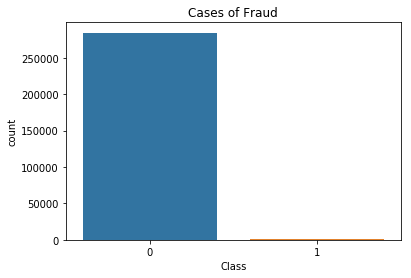

In [8]:
print(raw.Class.value_counts())
sns.countplot(raw.Class)
plt.title('Cases of Fraud')
plt.show()

We have only 492 cases of fraud!  That is incredibly imbalanced. With a situation like this we will focus on metrics like:
- **precision - how many selected instances are relevant**
    - What proportion of positive identifications was actually correct?
    - $\frac{TP}{TP+FP}$
- **specificity - true negative rate**
    - $\frac{TN}{TP+FN}$
- **recall/sensitivity - how many relevant instances are selected - true positive rate**
    - What proportion of actual positives was identified correctly?
    - $\frac{TP}{TP+FN}$
- **F1 score - harmonic mean of precision and recall**
- **percent of type1 error/type2 error**

**Precision says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect**

The most important metric of the ones above is going to be the recall because the recall is the true positive rate, which represents the actual number of fraud cases identified

We will also have to deal with the imbalance by under-sampling the data set.  With under-sampling we will keep all 492 fraud cases and randomly select 492 non-fraud cases.  With doing this we do run the risk of having too simple of a model because of the information loss of only selecting 492 cases of non-fraud from 280K.

(984, 31)
1    492
0    492
Name: Class, dtype: int64


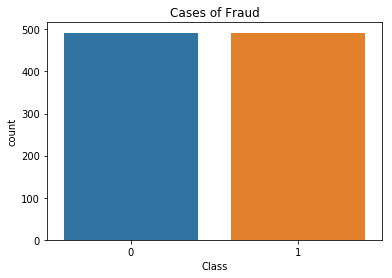

In [5]:
fraud = raw[raw.Class==1]
non_fraud = raw[raw.Class==0].sample(492)
undersample = pd.concat([fraud, non_fraud])

print(undersample.shape)
print(undersample.Class.value_counts())
sns.countplot(undersample.Class)
plt.title('Cases of Fraud')
plt.show()

Now we have a balanced dataset, albeit much smaller than the original but it should provide better protection from overfitting and mis-representing the relationships between the independent and dependent variables.  With a balanced dataset we will be able to better see how the independent variables effect the outcome.

Let's get a baseline for a number of different classifiers to find out how they are performing on our undersampled data set.

In [7]:
x = undersample.drop('Class',1)
y = undersample.Class

models = {'Logistic Regression':LogisticRegression(), 
          'KNN Classifier':KNeighborsClassifier(),
          'Decision Tree':DecisionTreeClassifier(), 
          'Random Forest':RandomForestClassifier(), 
          'Gradient Boosting':GradientBoostingClassifier(), 
          'Naive Bayes':BernoulliNB(), 
          'Support Vector':SVC()}

for key, model in models.items():
    # fit models
    model.fit(x, y)
    
    # Predict the model
    pred_y = model.predict(x)
    
    # score models
    score = cross_val_score(model, x, y, cv=5)
    print(key, "has a score of", round(score.mean(), 2) * 100,"% accuracy score")
    
    # Get the Precision, Recall, and F1 score
    precision = precision_score(y, pred_y)
    recall = recall_score(y, pred_y)
    f1 = f1_score(y, pred_y)
    
    # get the type 1 and type 2 errors
    table = pd.crosstab(y, model.predict(x), margins=True)
    type1 = table.loc[0.0, 1.0]/table.loc['All','All']
    type2 = table.loc[1.0, 0.0]/table.loc['All','All']    
    
    # display the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, pred_y).ravel()
    print(confusion_matrix(y, pred_y))
    
    # get the specificity
    specificity = tn/(tn+fp)
                                
    # create a table of info for each classifier
    print('Precision: {}\n'
           'Recall (True Positive Rate): {}\n'
           'Specificity (True Negative Rate): {}\n'
           'F1: {}'.format(precision, recall, specificity, f1))
    print('Percent type 1 error: {}'.format(type1))
    print('Percent type 2 error: {}'.format(type2))
    
    print('--'*40)

Logistic Regression has a score of 93.0 % accuracy score
[[488   4]
 [ 50 442]]
Precision: 0.9910313901345291
Recall (True Positive Rate): 0.8983739837398373
Specificity (True Negative Rate): 0.991869918699187
F1: 0.9424307036247334
Percent type 1 error: 0.0040650406504065045
Percent type 2 error: 0.0508130081300813
--------------------------------------------------------------------------------
KNN Classifier has a score of 36.0 % accuracy score
[[374 118]
 [124 368]]
Precision: 0.757201646090535
Recall (True Positive Rate): 0.7479674796747967
Specificity (True Negative Rate): 0.7601626016260162
F1: 0.7525562372188139
Percent type 1 error: 0.11991869918699187
Percent type 2 error: 0.12601626016260162
--------------------------------------------------------------------------------
Decision Tree has a score of 92.0 % accuracy score
[[492   0]
 [  0 492]]
Precision: 1.0
Recall (True Positive Rate): 1.0
Specificity (True Negative Rate): 1.0
F1: 1.0
Percent type 1 error: 0.0
Percent type 2

It looks like random forest classifier had the highest accuracy, the decision tree had the lowest accuracy but also had no type 1 or 2 errors.  The gradient boosting classifier had the second best accuracy and no type 1 error and second lowest type 2 error percentage.  Based on the information above I am going to move forward with the Gradient Boosting Classifier.  The next step will be to optimize the parameters using the GridSearchCV.

In [10]:
gbc = GradientBoostingClassifier()
gbc.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [11]:
params = {'n_estimators':[100,200,300],
          'loss':['deviance', 'exponential'], 
          'max_features':[None, 'sqrt', 'log2'],
          'subsample':[0.5, 0.75, 1], 
          'max_depth':range(2,9,2)}
clf =  GridSearchCV(gbc, params, cv=5)
clf.fit(x,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300], 'loss': ['deviance', 'exponential'], 'max_features': [None, 'sqrt', 'log2'], 'subsample': [0.5, 0.75, 1], 'max_depth': range(2, 9, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
params = clf.best_params_
print(params)

{'loss': 'deviance', 'max_depth': 6, 'max_features': None, 'n_estimators': 100, 'subsample': 1}


Now that we have the optimized parameters :
{'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.75} 
Let's get the info for the total dataset.

In [13]:
gbc = GradientBoostingClassifier(**params)
# fit models
gbc.fit(x, y)
    
# Predict the model
pred_y = gbc.predict(x)
    
# score models
score = cross_val_score(gbc, x, y, cv=5)
print("Gradient Boosting Classifier has a score of", round(score.mean(), 2) * 100,"% accuracy score")
    
# Get the Precision, Recall, and F1 score
precision = precision_score(y, pred_y)
recall = recall_score(y, pred_y)
f1 = f1_score(y, pred_y)
    
# get the type 1 and type 2 errors
table = pd.crosstab(y, gbc.predict(x), margins=True)
type1 = table.loc[0.0, 1.0]/table.loc['All','All']
type2 = table.loc[1.0, 0.0]/table.loc['All','All']    
    
# display the confusion matrix
tn, fp, fn, tp = confusion_matrix(y, pred_y).ravel()
print(confusion_matrix(y, pred_y))
    
# get the specificity
specificity = tn/(tn+fp)
                                                           
# create a table of info for each classifier
print('Precision: {}\n'
      'Recall (True Positive Rate): {}\n'
      'Specificity (True Negative Rate): {}\n'
      'F1: {}'.format(precision, recall, specificity, f1))
print('Percent type 1 error: {}'.format(type1))
print('Percent type 2 error: {}'.format(type2))

Gradient Boosting Classifier has a score of 94.0 % accuracy score
[[492   0]
 [  0 492]]
Precision: 1.0
Recall (True Positive Rate): 1.0
Specificity (True Negative Rate): 1.0
F1: 1.0
Percent type 1 error: 0.0
Percent type 2 error: 0.0


Now that we have this model fit for the fine tuned parameters. Let's see how it performs on the 'test' a.k.a the full data.

In [16]:
pred = gbc.predict(raw.drop('Class', 1))
score = gbc.score(raw.drop('Class', 1), raw.Class)
print("Gradient Boosting Classifier on full dataset has a score of", round(score, 2) * 100,"% accuracy score")

# Get the Precision, Recall, and F1 score
precision = precision_score(raw.Class, pred)
recall = recall_score(raw.Class, pred)
f1 = f1_score(raw.Class, pred)
    
# get the type 1 and type 2 errors
table = pd.crosstab(raw.Class, pred, margins=True)
type1 = table.loc[0.0, 1.0]/table.loc['All','All']
type2 = table.loc[1.0, 0.0]/table.loc['All','All']    
    
# display the confusion matrix
tn, fp, fn, tp = confusion_matrix(raw.Class, pred).ravel()
print(confusion_matrix(raw.Class, pred))
    
# get the specificity
specificity = tn/(tn+fp)
                                                           
# create a table of info for each classifier
print('Precision: {}\n'
      'Recall (True Positive Rate): {}\n'
      'Specificity (True Negative Rate): {}\n'
      'F1: {}'.format(precision, recall, specificity, f1))
print('Percent type 1 error: {}'.format(type1))
print('Percent type 2 error: {}'.format(type2))

print('-'*25)
print(classification_report(raw.Class, pred))

Gradient Boosting Classifier on full dataset has a score of 96.0 % accuracy score
[[271895  12420]
 [     0    492]]
Precision: 0.03810408921933085
Recall (True Positive Rate): 1.0
Specificity (True Negative Rate): 0.9563160578935336
F1: 0.07341092211280213
Percent type 1 error: 0.04360847872418866
Percent type 2 error: 0.0
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.04      1.00      0.07       492

   micro avg       0.96      0.96      0.96    284807
   macro avg       0.52      0.98      0.53    284807
weighted avg       1.00      0.96      0.98    284807



The final model is 96% accurate and has a recall of 100% which is great.  We were able to correctly identify all of the fraud, but also were identifying 4% of the data as fraud when it is not.  There is a trade-off between precision and recall that we have here, but I feel correctly identifying true fraud is the most important.

Things to talk about:
- Did the gridsearch only try to optimize the accuracy? Would I have to create a scorer to have it search to optimize the recall?
- Does training the model on the undersampled dataset suffice as a training model or would I still want to train and test the undersampled data?
- Since the data only contains numeric features V1, V2, ... V28 (plus Time and Amount) that are the principal components obtained with PCA - is there much feature engineering that we can do?  I eliminated outliers and scaled the data but did not search for relationships
- Precision is very low - do I want to play around with finding a cutoff on a a precision-recall curve to better balance these metrics?